# Hypothesis Testing in Healthcare: Drug Safety

A pharmaceutical company GlobalXYZ has just completed a randomized controlled drug trial. To promote transparency and reproducibility of the drug's outcome, they (GlobalXYZ) have presented the dataset to your organization, a non-profit that focuses primarily on drug safety.

The dataset provided contained five adverse effects, demographic data, vital signs, etc. Your organization is primarily interested in the drug's adverse reactions. It wants to know if the adverse reactions, if any, are of significant proportions. It has asked you to explore and answer some questions from the data.

The dataset `drug_safety.csv` was obtained from [Hbiostat](https://hbiostat.org/data/) courtesy of the Vanderbilt University Department of Biostatistics. It contained five adverse effects: headache, abdominal pain, dyspepsia, upper respiratory infection, chronic obstructive airway disease (COAD), demographic data, vital signs, lab measures, etc. The ratio of drug observations to placebo observations is 2 to 1.

For this project, the dataset has been modified to reflect the presence and absence of adverse effects `adverse_effects` and the number of adverse effects in a single individual `num_effects`.

The columns in the modified dataset are: 

| Column | Description |
|--------|-------------|
|`sex` | The gender of the individual |
|`age` | The age of the individual |
|`week` | The week of the drug testing |
|`trx` | The treatment (Drug) and control (Placebo) groups | 
|`wbc` | The count of white blood cells |
|`rbc` | The count of red blood cells |
|`adverse_effects` | The presence of at least a single adverse effect |
|`num_effects` | The number of adverse effects experienced by a single individual |

The original dataset can be found [here](https://hbiostat.org/data/repo/safety.rda)

In [1]:
# Import packages
import numpy as np
import pandas as pd
import pingouin
import seaborn as sns
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.proportion import proportions_ztest
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score #To split data
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier, VotingClassifier
from sklearn.metrics import mean_squared_error, r2_score, precision_score, accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay #For evaluating built models

In [154]:
drug = pd.read_csv(r"C:\Users\ADMIN\Downloads\github_com\drug_safety.csv")

In [155]:
drug.head(20)

,age,sex,trx,week,wbc,rbc,adverse_effects,num_effects
0,62,male,Drug,0,7.3,5.1,No,0
1,62,male,Drug,1,NaN,NaN,No,0
2,62,male,Drug,12,5.6,5.0,No,0
3,62,male,Drug,16,NaN,NaN,No,0
4,62,male,Drug,2,6.6,5.1,No,0
5,62,male,Drug,20,NaN,NaN,Yes,1
6,62,male,Drug,4,6.9,5.2,Yes,1
7,62,male,Drug,8,7.1,5.0,Yes,1
8,69,male,Drug,0,8.8,5.1,No,0
9,69,male,Drug,1,NaN,NaN,No,0


In [156]:
drug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16103 entries, 0 to 16102
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              16103 non-null  int64  
 1   sex              16103 non-null  object 
 2   trx              16103 non-null  object 
 3   week             16103 non-null  int64  
 4   wbc              9128 non-null   float64
 5   rbc              9127 non-null   float64
 6   adverse_effects  16103 non-null  object 
 7   num_effects      16103 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 1006.6+ KB


In [157]:
drug.describe()

,age,week,wbc,rbc,num_effects
count,16103.000000,16103.00000,9128.000000,9127.000000,16103.000000
mean,64.117556,7.74098,7.340557,4.672784,0.101596
std,8.783207,6.94350,1.996652,0.458520,0.323181
min,39.000000,0.00000,1.800000,2.100000,0.000000
25%,58.000000,1.00000,6.000000,4.400000,0.000000
50%,65.000000,4.00000,7.100000,4.700000,0.000000
75%,71.000000,12.00000,8.400000,5.000000,0.000000
max,84.000000,20.00000,26.500000,7.600000,3.000000


In [158]:
drug.isnull().sum()

age                   0
sex                   0
trx                   0
week                  0
wbc                6975
rbc                6976
adverse_effects       0
num_effects           0
dtype: int64

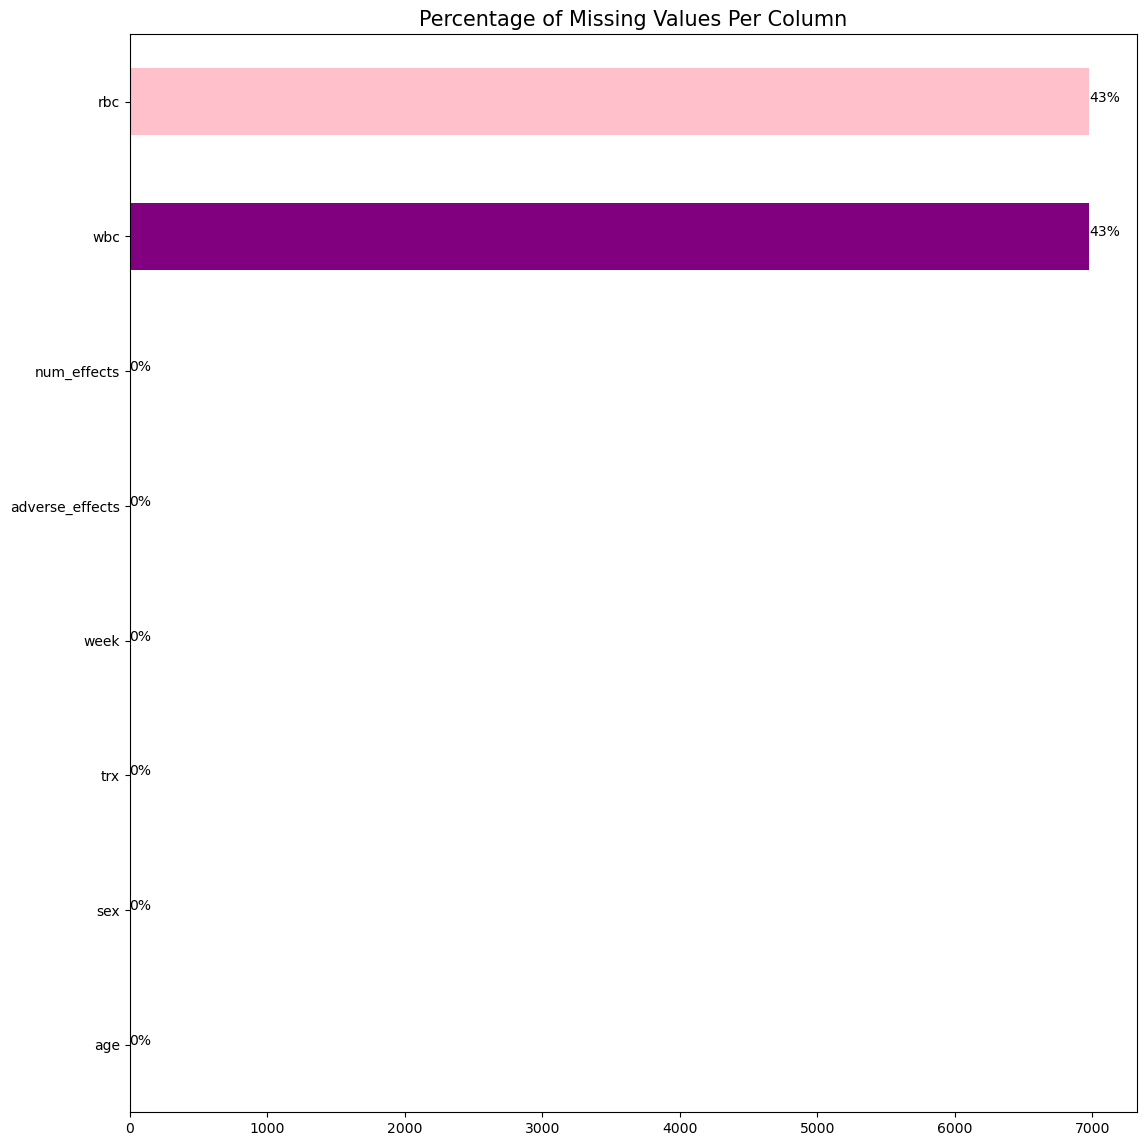

In [159]:
# Plot missing values
ax = drug.isna().sum().sort_values().plot(kind = 'barh', figsize = (13, 14), color=['purple', 'pink'])
plt.title('Percentage of Missing Values Per Column', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/drug.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [160]:
drug.duplicated().sum()

5791

In [161]:
drug.nunique()

age                 44
sex                  2
trx                  2
week                 8
wbc                154
rbc                143
adverse_effects      2
num_effects          4
dtype: int64

Text(0.5, 1.0, 'Distribution of the Number of Effects Between the Groups')

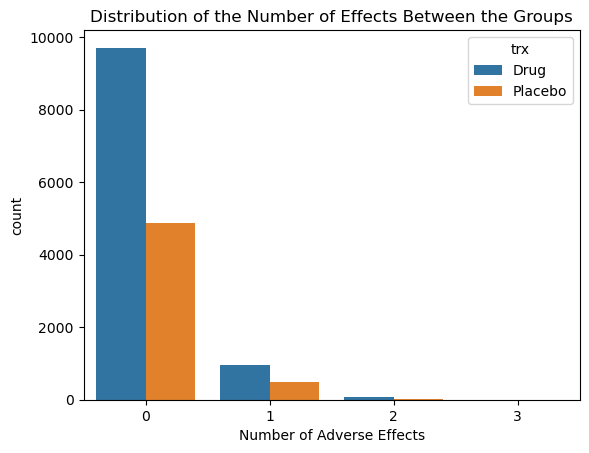

In [162]:
# Create a countplot of num_effects vs trx
# Store the output in plot_num_eff
plot_num_eff = sns.countplot(x="num_effects", data=drug, hue='trx')
# Set the x axis label and title
plt.xlabel("Number of Adverse Effects")
plt.title("Distribution of the Number of Effects Between the Groups")


In [163]:
# Count the adverse_effects column values for each trx group
adv_eff_by_trx = drug.groupby("trx").adverse_effects.value_counts()

# Compute total rows in each group
adv_eff_by_trx_totals = adv_eff_by_trx.groupby("trx").sum()

In [164]:
# Create an array of the "Yes" counts for each group
yeses = [adv_eff_by_trx["Drug"]["Yes"], adv_eff_by_trx["Placebo"]["Yes"]]

# Create an array of the total number of rows in each group
n = [adv_eff_by_trx_totals["Drug"], adv_eff_by_trx_totals["Placebo"]]


In [165]:
# Perform a two-sided z-test on the two proportions
two_samp_z_stat, two_samp_z_p_value = proportions_ztest(yeses, n)

# Round to three decimal places
two_samp_z_stat = np.round(two_samp_z_stat, 3)
two_samp_z_p_value = np.round(two_samp_z_p_value, 3)

In [166]:
# Determine if num_effects and trx are independent
expected, observed, stats = pingouin.chi2_independence(
    data=drug, x="num_effects", y="trx")

# Round the test statistics to three decimal places
stats = stats.round(3)

# Extract the Pearson row as pearson_num_effect_trx
pearson_num_effect_trx = stats[stats["test"] == "pearson"]


C:\Users\ADMIN\anaconda3_new\Lib\site-packages\pingouin\contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn(f"Low count on {name} frequencies.")
C:\Users\ADMIN\anaconda3_new\Lib\site-packages\pingouin\contingency.py:151: UserWarning: Low count on expected frequencies.
  warnings.warn(f"Low count on {name} frequencies.")


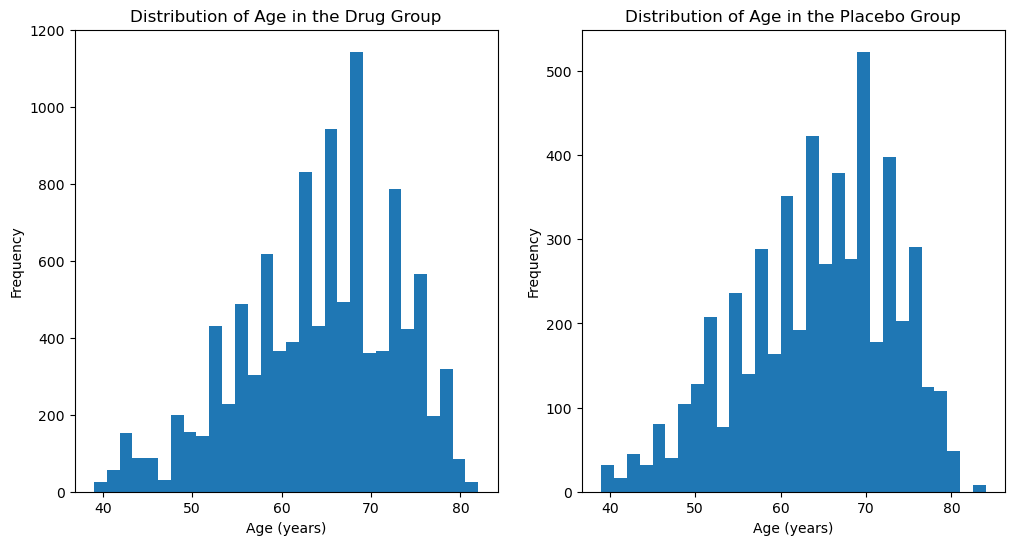

In [167]:
# Creating histograms to visualize the distribution of ages by treatment
# Create the plot axes. Increase the figure size
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Set x and y axes labels
xlabel = "Age (years)"
ylabel = "Frequency"

# The Drug group's age distribution
ax1.hist(x="age", data=drug[drug["trx"] == "Drug"], bins=30)
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)
ax1.set_title("Distribution of Age in the Drug Group")

# The Placebo group's age distribution
ax2.hist(x="age", data=drug[drug["trx"] == "Placebo"], bins=30)
ax2.set_xlabel(xlabel)
ax2.set_ylabel(ylabel)
ax2.set_title("Distribution of Age in the Placebo Group")

# Select the age of the Drug group
age_trx = drug.loc[drug["trx"] == "Drug", "age"]

# Select the age of the Placebo group
age_placebo = drug.loc[drug["trx"] == "Placebo", "age"]

# The distributions strongly suggest a
# non-parametric independent samples test.
# Conduct a two-sided Wilcoxon-Mann-Whitney test
# and round to three decimal places
two_ind_samp_results = pingouin.mwu(age_trx, age_placebo).round(3)

In [168]:
# The distributions strongly suggest a non-parametric independent samples test.
# Conduct a two-sided Wilcoxon-Mann-Whitney test and round to three decimal places
two_ind_samp_results = pingouin.mwu(age_trx, age_placebo).round(3)

## Handling missing values

In [169]:
#Handling missing values
drug["wbc"].fillna(drug["wbc"].mean(), inplace = True) 

In [170]:
#Handling missing values
drug["rbc"].fillna(drug["rbc"].mean(), inplace = True) 

In [171]:
drug.isnull().sum()

age                0
sex                0
trx                0
week               0
wbc                0
rbc                0
adverse_effects    0
num_effects        0
dtype: int64

In [172]:
drug.loc[:,  ["sex","trx","adverse_effects"]] = drug[["sex","trx","adverse_effects"]].apply(LabelEncoder().fit_transform)

In [173]:
drug.head(20)

,age,sex,trx,week,wbc,rbc,adverse_effects,num_effects
0,62,1,0,0,7.300000,5.100000,0,0
1,62,1,0,1,7.340557,4.672784,0,0
2,62,1,0,12,5.600000,5.000000,0,0
3,62,1,0,16,7.340557,4.672784,0,0
4,62,1,0,2,6.600000,5.100000,0,0
5,62,1,0,20,7.340557,4.672784,1,1
6,62,1,0,4,6.900000,5.200000,1,1
7,62,1,0,8,7.100000,5.000000,1,1
8,69,1,0,0,8.800000,5.100000,0,0
9,69,1,0,1,7.340557,4.672784,0,0


**Insights:**
- Sex: Male is 1 and Female is 0
- Drug: Drug is 0 and Placebo is 0

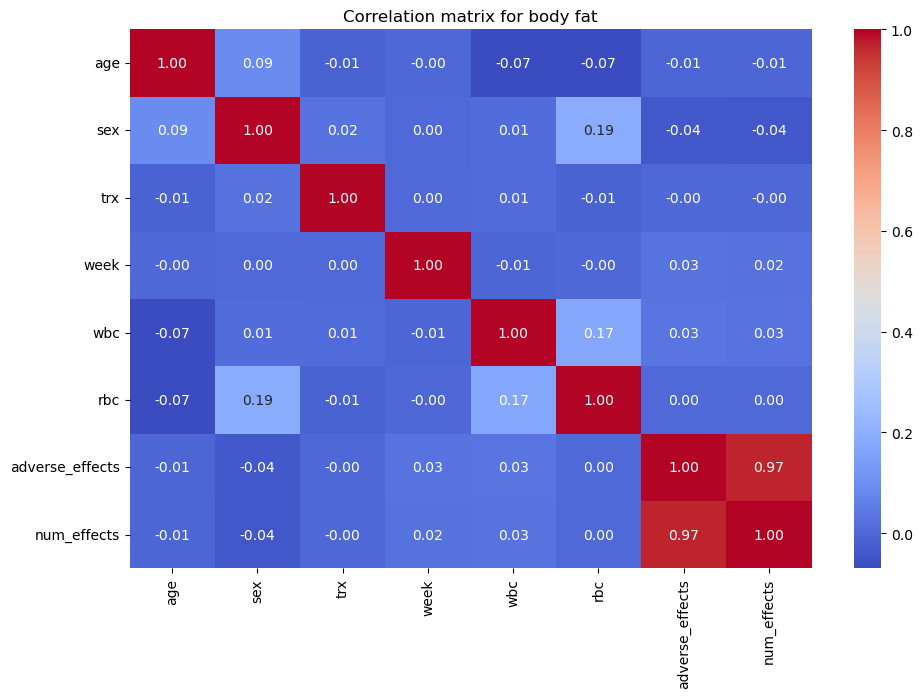

In [174]:
corel= drug.corr()

plt.figure(figsize=(11,7))
sns.heatmap(corel, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Correlation matrix for body fat")
plt.show()

### Feature Importance

In [175]:
# Checking for feature importance
drug1 = drug.copy()

X = drug1.drop('adverse_effects', axis=1)
y= drug1['adverse_effects']

best_features = SelectKBest(score_func=f_classif, k='all')
fit = best_features.fit(X, y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)
feature_scores = pd.concat([df_columns,df_scores],axis=1)
feature_scores.columns = ['features','scores']
feature_scores

,features,scores
0,age,0.425487
1,sex,22.535937
2,trx,0.002044
3,week,13.592291
4,wbc,18.768074
5,rbc,0.069185
6,num_effects,240592.443716


### Dropping over correlating column to avoid overfitting

In [193]:
drug = drug.drop(columns =['num_effects'])

In [194]:
drug

,age,sex,trx,week,wbc,rbc,adverse_effects
0,62,1,0,0,7.300000,5.100000,0
1,62,1,0,1,7.340557,4.672784,0
2,62,1,0,12,5.600000,5.000000,0
3,62,1,0,16,7.340557,4.672784,0
4,62,1,0,2,6.600000,5.100000,0
...,...,...,...,...,...,...,...
16098,78,1,1,16,7.340557,4.672784,1
16099,78,1,1,2,7.500000,4.900000,0
16100,78,1,1,20,7.340557,4.672784,1
16101,78,1,1,4,6.400000,4.800000,0


## Model Building

In [195]:
X = drug.drop('adverse_effects',axis=1)
y= drug['adverse_effects']

In [196]:
X.head()

,age,sex,trx,week,wbc,rbc
0,62,1,0,0,7.300000,5.100000
1,62,1,0,1,7.340557,4.672784
2,62,1,0,12,5.600000,5.000000
3,62,1,0,16,7.340557,4.672784
4,62,1,0,2,6.600000,5.100000


In [197]:
X.shape, y.shape

((16103, 6), (16103,))

In [198]:
#Converting our y_train and y_test to integer from object
y = y.astype(int)

### Balancing of the dataset.

In [199]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X, y)


In [200]:
X_train_balanced

,age,sex,trx,week,wbc,rbc
0,62,1.0,0.0,0,7.300000,5.100000
1,62,1.0,0.0,1,7.340557,4.672784
2,62,1.0,0.0,12,5.600000,5.000000
3,62,1.0,0.0,16,7.340557,4.672784
4,62,1.0,0.0,2,6.600000,5.100000
...,...,...,...,...,...,...
29129,48,0.0,0.362367,16,7.340557,4.672784
29130,64,1.0,0.693303,4,4.853348,4.284018
29131,77,1.0,0.857963,12,6.643760,4.357389
29132,72,0.395597,0.395597,12,7.158239,4.437358


In [201]:
y_train_balanced

0        0
1        0
2        0
3        0
4        0
        ..
29129    1
29130    1
29131    1
29132    1
29133    1
Name: adverse_effects, Length: 29134, dtype: int32

In [202]:
data = StandardScaler().fit_transform(X_train_balanced)

In [203]:
# Split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(data, y_train_balanced, test_size=0.3, 
                                                    random_state=42)

In [204]:
X_train

array([[ 4.60501542e-01,  5.97291511e-01, -7.26547896e-01,
        -2.42941295e-03, -1.80350176e+00, -1.35155163e+00],
       [-1.14624896e+00, -1.83966963e+00, -7.26547896e-01,
         1.16505128e+00, -3.99211618e-02, -1.00659715e-02],
       [ 8.04805220e-01,  5.97291511e-01, -7.26547896e-01,
        -1.02397502e+00, -3.99211618e-02, -1.00659715e-02],
       ...,
       [ 1.60818047e+00,  5.97291511e-01, -7.26547896e-01,
        -5.86169758e-01, -4.08384830e-01, -8.68926082e-01],
       [ 1.42996997e-03,  5.97291511e-01, -7.26547896e-01,
        -8.78039931e-01, -1.36267789e+00, -5.54076449e-01],
       [ 1.60818047e+00, -1.79374476e-01, -7.26547896e-01,
        -8.78039931e-01, -1.98074957e-01, -3.80698865e-01]])

In [205]:
print(np.unique(y_train))
print(y_train[:10]) 

[0 1]
21560    1
26476    1
26915    1
9707     0
19875    1
23424    1
9410     0
11374    0
28676    1
1760     0
Name: adverse_effects, dtype: int32


In [206]:
y_train, y_test

(21560    1
 26476    1
 26915    1
 9707     0
 19875    1
         ..
 21575    1
 5390     0
 860      1
 15795    0
 23654    1
 Name: adverse_effects, Length: 20393, dtype: int32,
 20241    1
 6134     0
 6424     0
 8943     0
 14725    0
         ..
 10352    0
 17933    1
 22193    1
 9253     0
 17638    1
 Name: adverse_effects, Length: 8741, dtype: int32)

In [207]:
classification_evals = {}

def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(np.array(X_train)))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(np.array(X_test)))
    train_precision = metrics.precision_score(y_train, model.predict(np.array(X_train)))
    test_precision = metrics.precision_score(y_test, model.predict(np.array(X_test)))
    train_recall = metrics.recall_score(y_train, model.predict(np.array(X_train)))
    test_recall = metrics.recall_score(y_test, model.predict(np.array(X_test)))

    classification_evals[name] = {
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Train Precision': train_precision,
        'Test Precision': test_precision,
        'Train Recall': train_recall,
        'Test Recall': test_recall
    }

    print("Training Accuracy " + str(name) + ": {:.2f}".format(train_accuracy * 100))
    print("Test Accuracy " + str(name) + ": {:.2f}".format(test_accuracy * 100))
    print("Training Precision " + str(name) + ": {:.2f}".format(train_precision * 100))
    print("Test Precision " + str(name) + ": {:.2f}".format(test_precision * 100))
    print("Training Recall " + str(name) + ": {:.2f}".format(train_recall * 100))
    print("Test Recall " + str(name) + ": {:.2f}".format(test_recall * 100))

    # Plot the confusion matrix
    actual = y_test
    predicted = model.predict(np.array(X_test))
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['Normal','adverse_effect'])

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.grid(False)
    cm_display.plot(ax=ax)

### KNeighbors Classifier

Training Accuracy KNeighborsClassifier: 75.89
Test Accuracy KNeighborsClassifier: 72.44
Training Precision KNeighborsClassifier: 76.00
Test Precision KNeighborsClassifier: 72.21
Training Recall KNeighborsClassifier: 75.82
Test Recall KNeighborsClassifier: 72.53


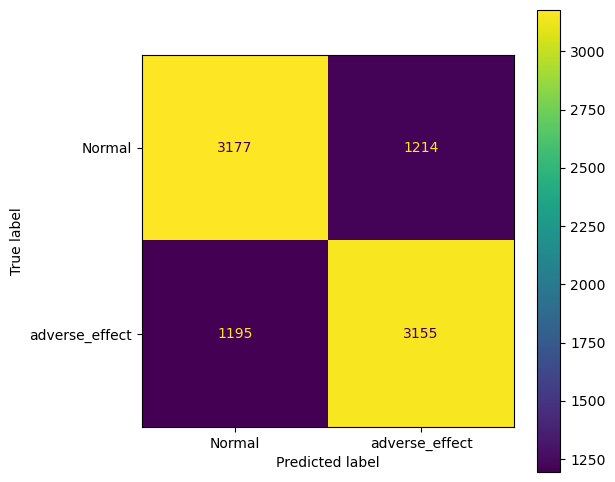

In [208]:
knn = KNeighborsClassifier(n_neighbors=15).fit(X_train, y_train)
evaluate_classification(knn, "KNeighborsClassifier", X_train, X_test, y_train, y_test)

### Decision Tree Classifier

Training Accuracy DecisionTreeClassifier: 90.33
Test Accuracy DecisionTreeClassifier: 81.83
Training Precision DecisionTreeClassifier: 89.90
Test Precision DecisionTreeClassifier: 81.10
Training Recall DecisionTreeClassifier: 90.92
Test Recall DecisionTreeClassifier: 82.78


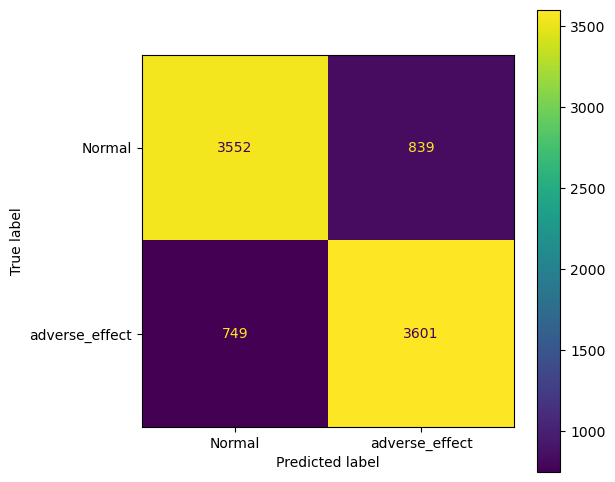

In [209]:
dt = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
tdt = DecisionTreeClassifier().fit(X_train, y_train)
evaluate_classification(tdt, "DecisionTreeClassifier", X_train, X_test, y_train, y_test)

### Random Forest

Training Accuracy RandomForestClassifier: 90.33
Test Accuracy RandomForestClassifier: 84.46
Training Precision RandomForestClassifier: 89.77
Test Precision RandomForestClassifier: 85.45
Training Recall RandomForestClassifier: 91.07
Test Recall RandomForestClassifier: 82.90


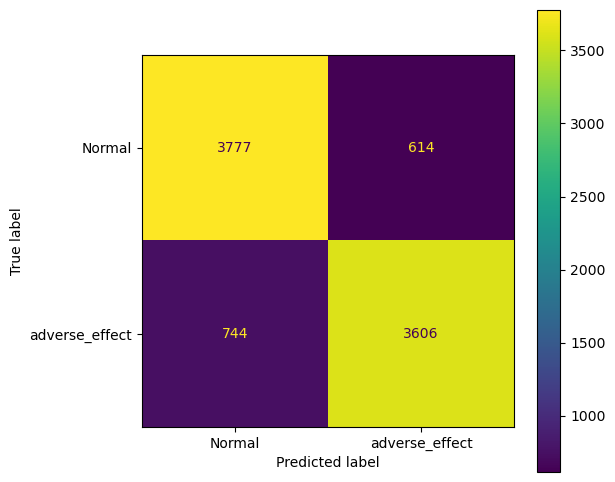

In [146]:
rf = RandomForestClassifier().fit(X_train, y_train)
evaluate_classification(rf, "RandomForestClassifier", X_train, X_test, y_train, y_test)

### XG_boost

Training Accuracy XGBClassifier: 86.22
Test Accuracy XGBClassifier: 84.40
Training Precision XGBClassifier: 90.83
Test Precision XGBClassifier: 88.96
Training Recall XGBClassifier: 80.63
Test Recall XGBClassifier: 78.37


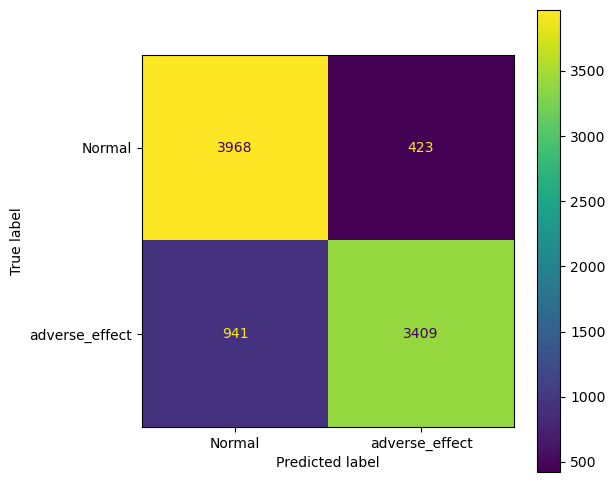

In [148]:
xgb = XGBClassifier().fit(X_train, y_train)
evaluate_classification(xgb, "XGBClassifier", X_train, X_test, y_train, y_test)

### Voting Classifier

In [150]:
# Create base classifiers for the ensemble
base_classifier_dt = DecisionTreeClassifier()
base_classifier_knn = KNeighborsClassifier(n_neighbors=20)
base_classifier_rf = RandomForestClassifier()
base_classifier_xgb = XGBClassifier()

In [151]:
voting_classifier = VotingClassifier(
    estimators=[
        ('dt', base_classifier_dt),
        ('knn', base_classifier_knn),
        ('rf', base_classifier_rf),
        ('xgb', base_classifier_xgb)
    ],
    voting='soft'  # Use 'soft' voting for probabilities, or 'hard' for majority voting
)

In [152]:
# Fit the voting ensemble on the training data
voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier()),
                             ('knn', KNeighborsClassifier(n_neighbors=20)),
                             ('rf', RandomForestClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_typ...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))],
                 voting='soft')

Training Accuracy VotingClassifier: 90.17
Test Accuracy VotingClassifier: 84.33
Training Precision VotingClassifier: 90.45
Test Precision VotingClassifier: 85.12
Training Recall VotingClassifier: 89.86
Test Recall VotingClassifier: 83.01


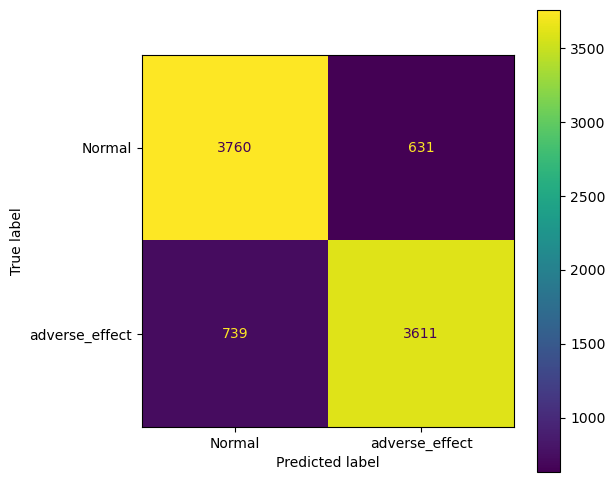

In [153]:
# Evaluate the voting classifier
evaluate_classification(voting_classifier, "VotingClassifier", X_train, X_test, y_train, y_test)